In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import time
import itertools


from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [22]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    features = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test


In [23]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_42749/2131301573.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


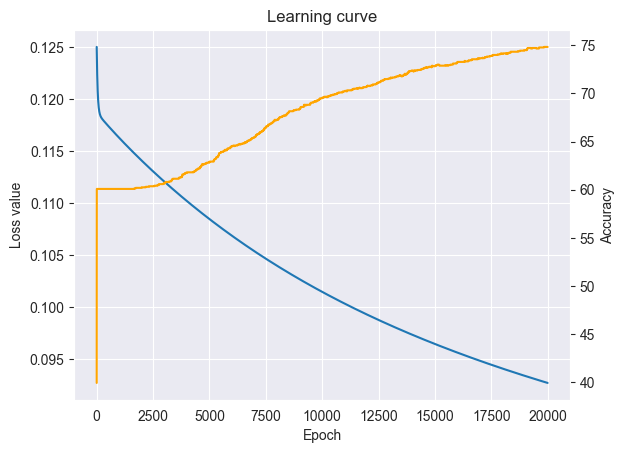

The final train accuracy: 74.83296213808464%
Test accuracy: 84.18708240534521%


In [25]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_01',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_reg = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_reg, 'MSE': mean_squared_error}

model_regression = LogisticRegression(w, b, optimizer)
metrics_history = model_regression.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)

# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {metrics_history["accuracy"][-1]}%')
print(f'Test accuracy: {accuracy_reg(model_regression.decision_function(X_test), Y_test)}%')


In [26]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    start = time.time()
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_poly(X_test), Y_test)

    train_acc = binary_accuracy(svm_poly(X_train), Y_train)

    print(f'Test accuracy degree {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")

sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    start = time.time()
    svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_rbf(X_test), Y_test)

    train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

    print(f'Test accuracy sigma {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")


Test accuracy degree 0: 55.0111, Train accuracy: 60.0780
⏱️ Train time: 3.7070 seconds
Test accuracy degree 1: 68.3742, Train accuracy: 84.1871
⏱️ Train time: 5.4052 seconds
Test accuracy degree 2: 55.9020, Train accuracy: 90.1448
⏱️ Train time: 5.3021 seconds
Test accuracy degree 3: 55.6793, Train accuracy: 91.9265
⏱️ Train time: 5.8601 seconds
Test accuracy degree 4: 54.7884, Train accuracy: 92.6503
⏱️ Train time: 5.4515 seconds
Test accuracy degree 5: 57.9065, Train accuracy: 92.9844
⏱️ Train time: 5.0356 seconds
Test accuracy degree 6: 61.9154, Train accuracy: 94.1537
⏱️ Train time: 5.4279 seconds
Test accuracy degree 7: 61.9154, Train accuracy: 94.3764
⏱️ Train time: 6.1668 seconds
Test accuracy degree 8: 57.6837, Train accuracy: 89.9777
⏱️ Train time: 7.4135 seconds
Test accuracy degree 9: 59.2428, Train accuracy: 91.2027
⏱️ Train time: 7.9733 seconds
Test accuracy sigma 0.01: 55.0111, Train accuracy: 100.0000
⏱️ Train time: 3.5324 seconds
Test accuracy sigma 0.05: 55.0111, Train

In [33]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_-1', train_frac=0.8)
X_train = min_max(X_train)
X_test = min_max(X_test)
X = min_max(X)

svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_train, Y_train)

test_acc = binary_accuracy(svm_rbf(X_test), Y_test)

train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

Test accuracy sigma 1: 74.3875, Train accuracy: 82.9621


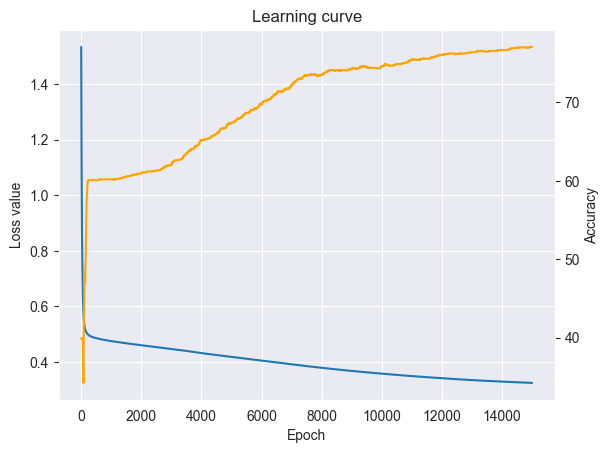

The final train accuracy: 77.1%
Test accuracy: 82.9%


In [27]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history = model.fit(X_train, Y_train, num_epochs=15000, batch_size=len(X_train), compute_metrics=True,
                            metrics_dict=metrics_dict)

fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test), 1)}%')


Test accuracy: 0.0%
